In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import pandas as pd
import requests
from tqdm import tqdm
import os
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
from datasets import load_dataset

dataset = load_dataset("amazon_us_reviews", "Apparel_v1_00")
train_data = dataset['train']

# Limit the dataset to the first 10,000 rows
train_data = train_data.select(range(10000))

df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame
df = df[['customer_id', 'review_headline', 'review_body', 'star_rating']]  # Select specific columns
df.columns = ['customer_id', 'review_headline', 'review_body', 'star_rating']  # Rename the selected columns
df.set_index('customer_id', inplace=True)
df.head()  # Display the first few rows of the DataFrame

Found cached dataset amazon_us_reviews (/home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

,review_headline,review_body,star_rating
customer_id,,,
32158956,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",4
2714559,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,5
12608825,Great Socks for the money.,"Nice socks, great colors, just enough support ...",5
25482800,Slick hat!,"I bought this for my husband and WOW, this is ...",5
9310286,I would do it again!,Perfect dress and the customer service was awe...,5


In [3]:
df.star_rating.value_counts()

star_rating
5    5941
4    1585
1    1095
3     819
2     560
Name: count, dtype: int64

In [4]:
df['sentiment'] = df['star_rating'].map({5: 'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'})

In [5]:
df['sentiment'].value_counts()

sentiment
good       7526
bad        1655
neutral     819
Name: count, dtype: int64

In [6]:
possible_labels = df.sentiment.unique() #Get unique category labels from the DataFrame column 'category'

In [7]:
label_dict = {} #Create a dictionary to map each possible label to a unique index
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [8]:
label_dict

{'good': 0, 'neutral': 1, 'bad': 2}

In [9]:
df['label'] = df.sentiment.replace(label_dict)
df.head(10)

,review_headline,review_body,star_rating,sentiment,label
customer_id,,,,,
32158956,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",4,good,0
2714559,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,5,good,0
12608825,Great Socks for the money.,"Nice socks, great colors, just enough support ...",5,good,0
25482800,Slick hat!,"I bought this for my husband and WOW, this is ...",5,good,0
9310286,I would do it again!,Perfect dress and the customer service was awe...,5,good,0
26631939,Five Stars,Excellent for my 6 feet skinny 15 years old boy.,5,good,0
48785098,Love it!,Raw is the only way to go! Absolutely love thi...,5,good,0
39548589,Three Stars,A bit large.,4,good,0
29355866,Five Stars,Great fit!,5,good,0


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
#Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.15,
    random_state=17,
    stratify=df.label.values
)

In [12]:
df['data_type'] = ['not_set']*df.shape[0] #Set a new column 'data_type' for later data split

In [13]:
df.head()

,review_headline,review_body,star_rating,sentiment,label,data_type
customer_id,,,,,,
32158956,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",4,good,0,not_set
2714559,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,5,good,0,not_set
12608825,Great Socks for the money.,"Nice socks, great colors, just enough support ...",5,good,0,not_set
25482800,Slick hat!,"I bought this for my husband and WOW, this is ...",5,good,0,not_set
9310286,I would do it again!,Perfect dress and the customer service was awe...,5,good,0,not_set


In [14]:
#Set the 'data_type' column of the dataframe for training and validation data
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [15]:
df.groupby(['star_rating', 'label', 'data_type']).count()

review_headline  review_body  sentiment
star_rating label data_type                                         
1           2     train                  932          932        932
                  val                    163          163        163
2           2     train                  459          459        459
                  val                    101          101        101
3           1     train                  682          682        682
                  val                    137          137        137
4           0     train                 1307         1307       1307
                  val                    278          278        278
5           0     train                 4620         4620       4620
                  val                   1321         1321       1321

In [16]:
from transformers import GPT2Tokenizer, TFGPT2Model
import tensorflow as tf
from torch.utils.data import TensorDataset

2023-06-08 18:38:37.249601: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 18:38:37.741104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 18:38:39.707960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
tokenizer = GPT2Tokenizer.from_pretrained(
    "michelecafagna26/gpt2-medium-finetuned-sst2-sentiment",
    do_lower_case=True
)

In [18]:
encoded_data_train_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_train_body = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train_headline = encoded_data_train_headline['input_ids']
attention_masks_train_headline = encoded_data_train_headline['attention_mask']

input_ids_train_body = encoded_data_train_body['input_ids']
attention_masks_train_body = encoded_data_train_body['attention_mask']

input_ids_train = torch.cat((input_ids_train_headline, input_ids_train_body), dim=1)
attention_masks_train = torch.cat((attention_masks_train_headline, attention_masks_train_body), dim=1)

labels_train = torch.tensor(df[df.data_type=='train'].label.values)


encoded_data_val_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val_body = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val_headline = encoded_data_val_headline['input_ids']
attention_masks_val_headline = encoded_data_val_headline['attention_mask']

input_ids_val_body = encoded_data_val_body['input_ids']
attention_masks_val_body = encoded_data_val_body['attention_mask']

input_ids_val = torch.cat((input_ids_val_headline, input_ids_val_body), dim=1)
attention_masks_val = torch.cat((attention_masks_val_headline, attention_masks_val_body), dim=1)

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [19]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [20]:
len(dataset_train)

8000

In [21]:
len(dataset_val)

2000

In [22]:
from transformers import GPT2ForSequenceClassification, GPT2Config

In [23]:
# Define a GPT model for sequence classification task with dropout
model_config = GPT2Config.from_pretrained(
    'michelecafagna26/gpt2-medium-finetuned-sst2-sentiment',
    ignore_mismatched_sizes=True,
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.3,  # Set the dropout rate (0.1 means 10% dropout)
    attention_probs_dropout_prob=0.1  # Set the attention dropout rate
)

model = GPT2ForSequenceClassification.from_pretrained(
    'michelecafagna26/gpt2-medium-finetuned-sst2-sentiment',
    ignore_mismatched_sizes=True,
    config=model_config
)

"""
Here, I use the GPT2ForSequenceClassification model, which is a GPT model for sequence classification
task such as sentiment analysis. The pre-trained GPT model is loaded from 'gpt2', and we set the number of labels to be the length of unique labels in the dataset.

I also set output_attentions and output_hidden_states to False, which means I only get the output
from the last layer of GPT.
"""

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at michelecafagna26/gpt2-medium-finetuned-sst2-sentiment and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


"\nHere, I use the GPT2ForSequenceClassification model, which is a GPT model for sequence classification\ntask such as sentiment analysis. The pre-trained GPT model is loaded from 'gpt2', and we set the number of labels to be the length of unique labels in the dataset.\n\nI also set output_attentions and output_hidden_states to False, which means I only get the output\nfrom the last layer of GPT.\n"

In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [25]:
# Set the batch size and create data loaders for training and validation sets

batch_size = 1 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [26]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [27]:
optimizer = AdamW(
    model.parameters(),  # Passes the model parameters to the optimizer
    lr=1e-5,             # Sets the learning rate for the optimizer to 1e-5
    eps=1e-8             # Sets the epsilon value for numerical stability to 1e-8
)

/home/z123010/.local/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
epochs = 10 #This sets the number of epochs or the number of times the model will iterate over the entire dataset during training to 10.

#This creates a linear learning rate scheduler that increases the learning rate linearly over the course of training and uses the specified number of warm-up steps and total training steps.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, #This sets the number of warm-up steps during training to 0. Warm-up steps gradually increase the learning rate from an initial low value to the target learning rate.
    num_training_steps=len(dataloader_train)*epochs #This sets the number of total training steps to the number of batches per epoch times the number of epochs.
)

In [29]:
import numpy as np

In [30]:
from sklearn.metrics import f1_score #F1 score is a measure of a model's accuracy, combining both precision and recall, used to evaluate binary classification models.

In [31]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

In [32]:
def accuracy_per_class(preds, labels):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Print the class name, accuracy numerator and denominator.
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [33]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [34]:
torch.cuda.empty_cache()
device = torch.device('cuda')
model.to(device)

print(device)

cuda


In [35]:
#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):
    torch.cuda.empty_cache()

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals




In [36]:
import torch

torch.cuda.empty_cache()
torch.backends.cuda.max_split_size_mb = 5500

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
data = torch.randn([1, 3, 470, 446], dtype=torch.float, device='cuda', requires_grad=True)
net = torch.nn.Conv2d(3, 64, kernel_size=[7, 7], padding=[0, 0], stride=[1, 1], dilation=[1, 1], groups=1)
net = net.cuda().float()
out = net(data)
out.backward(torch.randn_like(out))
torch.cuda.synchronize()
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [37]:
import time
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.pyplot as plt
from tabulate import tabulate

total_training_time = 0

training_loss_list = []
validation_loss_list = []
accuracy_list = []
precision_list = []
f1_score_list = []

previous_results = None  # Store previous epoch results

for epoch in tqdm(range(1, epochs + 1)):
    start_time = time.time()

    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        output = model(**inputs)
        loss = output[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    torch.save(model.state_dict(), f'Models/finetuned_gpt_ft_epoch{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_val)

    # Convert predictions to discrete labels
    predictions = np.argmax(predictions, axis=1)

    val_f1 = f1_score(true_vals, predictions, average='weighted')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

    val_accuracy = accuracy_score(true_vals, predictions)
    val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)

    # Compute and store metrics
    training_loss_list.append(loss_train_avg)
    validation_loss_list.append(val_loss)
    f1_score_list.append(val_f1)
    accuracy_list.append(val_accuracy)
    precision_list.append(val_precision)

    # Check if there are previous results to compare with
    if previous_results is not None:
        if loss_train_avg > previous_results['loss_train_avg']:
            percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
            tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
        if loss_train_avg < previous_results['loss_train_avg']:
            percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
            tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
        if val_loss > previous_results['val_loss']:
            percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
            tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
        if val_loss < previous_results['val_loss']:
            percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
            tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
        if val_f1 < previous_results['val_f1']:
            percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
            tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
        if val_f1 > previous_results['val_f1']:
            percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
            tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')

    # Store current results as previous results for the next epoch
    previous_results = {
        'loss_train_avg': loss_train_avg,
        'val_loss': val_loss,
        'val_f1': val_f1
    }

total_time_minutes = total_training_time / 60
tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')

final_accuracy = accuracy_list[-1]
final_precision = precision_list[-1]
tqdm.write(f'Final Accuracy: {final_accuracy}')
tqdm.write(f'Final Precision: {final_precision}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7877990549900165
Validation loss: 0.5301238483850528
F1 Score (weighted): 0.8998242417353538


Epoch 2:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5263102262883297
Validation loss: 0.603685094278327
F1 Score (weighted): 0.9013521547374179
33.19% Training loss decreased compared to the previous epoch
13.88% Validation loss increased compared to the previous epoch
0.17% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.4063178480465813
Validation loss: 0.5212707711459891
F1 Score (weighted): 0.9150092908860833
22.8% Training loss decreased compared to the previous epoch
13.65% Validation loss decreased compared to the previous epoch
1.52% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2886460244302772
Validation loss: 0.6698079724359519
F1 Score (weighted): 0.9125009840967528
28.96% Training loss decreased compared to the previous epoch
28.5% Validation loss increased compared to the previous epoch
0.27% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.21264318988865302
Validation loss: 0.7458877979160194
F1 Score (weighted): 0.9148914480137609
26.33% Training loss decreased compared to the previous epoch
11.36% Validation loss increased compared to the previous epoch
0.26% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.16155365980962177
Validation loss: 0.7859709551783935
F1 Score (weighted): 0.912150898575938
24.03% Training loss decreased compared to the previous epoch
5.37% Validation loss increased compared to the previous epoch
0.3% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.1224406317775764
Validation loss: 0.8398463694780367
F1 Score (weighted): 0.9149943420525003
24.21% Training loss decreased compared to the previous epoch
6.85% Validation loss increased compared to the previous epoch
0.31% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.09478825530056431
Validation loss: 0.8957523404054359
F1 Score (weighted): 0.9161891595938737
22.58% Training loss decreased compared to the previous epoch
6.66% Validation loss increased compared to the previous epoch
0.13% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.08094821078419662
Validation loss: 0.868563956280083
F1 Score (weighted): 0.9138013124789085
14.6% Training loss decreased compared to the previous epoch
3.04% Validation loss decreased compared to the previous epoch
0.26% F1 Score decreased compared to the previous epoch


Epoch 10:   0%|          | 0/8000 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.06043913237078562
Validation loss: 0.8557203198980615
F1 Score (weighted): 0.9176482941277017
25.34% Training loss decreased compared to the previous epoch
1.48% Validation loss decreased compared to the previous epoch
0.42% F1 Score increased compared to the previous epoch

Total training time: 248.13733305136364 minutes
Final Accuracy: 0.9175
Final Precision: 0.9179006894395708


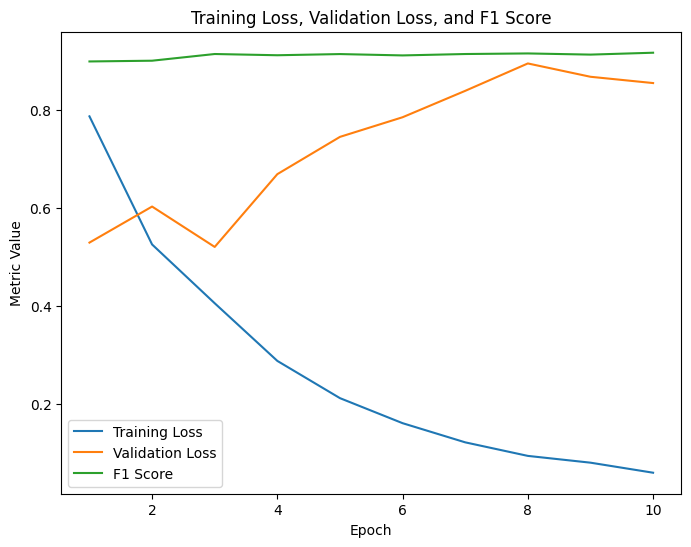

In [38]:
# Create a single subplot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot training loss
ax.plot(range(1, epochs + 1), training_loss_list, label='Training Loss')

# Plot validation loss
ax.plot(range(1, epochs + 1), validation_loss_list, label='Validation Loss')

# Plot F1-score
ax.plot(range(1, epochs + 1), f1_score_list, label='F1 Score')

# Set labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric Value')
ax.set_title('Training Loss, Validation Loss, and F1 Score')

# Set legend
ax.legend()

# Show the combined plot
plt.show()

In [39]:
# Create the metrics table
metrics_table = [
    ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
]
previous_results = None
for epoch in range(1, epochs + 1):
    row = [
        epoch,
        training_loss_list[epoch - 1],
        validation_loss_list[epoch - 1],
        f1_score_list[epoch - 1],
        accuracy_list[epoch - 1],
        precision_list[epoch - 1]
    ]

    # Compare with previous epoch results
    if previous_results is not None:
        if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
            row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
        if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
            row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
        if validation_loss_list[epoch - 1] < previous_results['val_loss']:
            row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
        if validation_loss_list[epoch - 1] > previous_results['val_loss']:
            row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
        if f1_score_list[epoch - 1] > previous_results['val_f1']:
            row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
        if f1_score_list[epoch - 1] < previous_results['val_f1']:
            row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red

    metrics_table.append(row)
    previous_results = {
        'loss_train_avg': training_loss_list[epoch - 1],
        'val_loss': validation_loss_list[epoch - 1],
        'val_f1': f1_score_list[epoch - 1]
    }

# Calculate total training time in minutes
total_time_minutes = total_training_time / 60

# Calculate total precision
total_precision = precision_list[-1]

# Add total training time and total precision rows to the table
metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
metrics_table.append(['Final Precision', '', '', '', '', total_precision])
metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])

# Print the table
print(tabulate(metrics_table, headers='firstrow'))

Epoch                 Training Loss        Validation Loss     F1 Score            Accuracy       Precision
--------------------  -------------------  ------------------  ------------------  ----------  ------------
1                     0.7877990549900165   0.5301238483850528  0.8998242417353538  0.9135          0.917623
2                     0.5263102262883297   0.603685094278327   0.9013521547374179  0.9125          0.909586
3                     0.4063178480465813   0.5212707711459891  0.9150092908860833  0.919           0.912907
4                     0.2886460244302772   0.6698079724359519  0.9125009840967528  0.91            0.91541
5                     0.21264318988865302  0.7458877979160194  0.9148914480137609  0.914           0.915855
6                     0.16155365980962177  0.7859709551783935  0.912150898575938   0.914           0.910918
7                     0.1224406317775764   0.8398463694780367  0.9149943420525003  0.918           0.912803
8                     0.09478